In [1]:
import numpy as np
import pandas as pd 


from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('../datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()
data_shift

,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [3]:
p_train = 0.8

train_set = data_shift.iloc[:int(143*0.8)]
valid_set = data_shift.iloc[int(143*0.8):]

In [4]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

n_steps = 12
train_x,train_y = split_sequence(np.array(train_set['#Passengers']),n_steps)
valid_x,valid_y = split_sequence(np.array(valid_set['#Passengers']),n_steps)

In [5]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [6]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.fc1 = nn.Linear(12,1)
        
    def forward(self,x):
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        
        
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [8]:
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

13

In [9]:
train = ElecDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid = ElecDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
train_loader = torch.utils.data.DataLoader(train,batch_size=3,shuffle=False)
valid_loader = torch.utils.data.DataLoader(train,batch_size=3,shuffle=False)

In [10]:
train

In [11]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        preds = torch.reshape(preds, (-1,))
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            preds = torch.reshape(preds, (-1,))
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')
        return valid_loss

In [12]:
epochs = 2000 # Se necesitan varias iteraciones
max_no_improve = 5;
no_improve = 0;
tol = 0.00001
min_loss = np.Inf
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    loss_valid = Valid()
    if(min_loss > loss_valid):
        min_loss = loss_valid
    if(np.abs(min_loss - loss_valid) < tol):
        no_improve = 0
    else:
        no_improve = no_improve + 1
    if(max_no_improve < no_improve):
        break
        
    gc.collect()

epochs 1/2000
train_loss 0.012935432605445385
valid_loss 0.012741564773023129
epochs 2/2000
train_loss 0.012563499622046947
valid_loss 0.012383022345602512
epochs 3/2000
train_loss 0.012215991504490376
valid_loss 0.012047148309648037
epochs 4/2000
train_loss 0.01189052127301693
valid_loss 0.011732377111911774
epochs 5/2000
train_loss 0.011585474014282227
valid_loss 0.011437241919338703
epochs 6/2000
train_loss 0.011299422942101955
valid_loss 0.011160394176840782
epochs 7/2000
train_loss 0.01103103905916214
valid_loss 0.01090056262910366
epochs 8/2000
train_loss 0.01077908556908369
valid_loss 0.010656544007360935
epochs 9/2000
train_loss 0.010542390868067741
valid_loss 0.010427203960716724
epochs 10/2000
train_loss 0.010319842025637627
valid_loss 0.010211464948952198
epochs 11/2000
train_loss 0.01011040061712265
valid_loss 0.010008316487073898
epochs 12/2000
train_loss 0.00991307944059372
valid_loss 0.009816803969442844
epochs 13/2000
train_loss 0.009726949036121368
valid_loss 0.0096360

epochs 106/2000
train_loss 0.003812291193753481
valid_loss 0.003797087585553527
epochs 107/2000
train_loss 0.0037842821329832077
valid_loss 0.0037692696787416935
epochs 108/2000
train_loss 0.003756652818992734
valid_loss 0.003741829190403223
epochs 109/2000
train_loss 0.003729399526491761
valid_loss 0.0037147612310945988
epochs 110/2000
train_loss 0.00370251527056098
valid_loss 0.003688060212880373
epochs 111/2000
train_loss 0.0036759949289262295
valid_loss 0.003661721246317029
epochs 112/2000
train_loss 0.0036498357076197863
valid_loss 0.0036357406061142683
epochs 113/2000
train_loss 0.003624031087383628
valid_loss 0.0036101120058447123
epochs 114/2000
train_loss 0.0035985771100968122
valid_loss 0.0035848321858793497
epochs 115/2000
train_loss 0.003573469817638397
valid_loss 0.0035598960239440203
epochs 116/2000
train_loss 0.003548703156411648
valid_loss 0.003535298863425851
epochs 117/2000
train_loss 0.003524273866787553
valid_loss 0.003511035582050681
epochs 118/2000
train_loss 0.00

epochs 208/2000
train_loss 0.002279110951349139
valid_loss 0.0022745432797819376
epochs 209/2000
train_loss 0.002272619167342782
valid_loss 0.002268098061904311
epochs 210/2000
train_loss 0.002266224706545472
valid_loss 0.0022617499344050884
epochs 211/2000
train_loss 0.0022599268704652786
valid_loss 0.0022554972674697638
epochs 212/2000
train_loss 0.0022537228651344776
valid_loss 0.002249337499961257
epochs 213/2000
train_loss 0.0022476124577224255
valid_loss 0.0022432710975408554
epochs 214/2000
train_loss 0.0022415940184146166
valid_loss 0.0022372957319021225
epochs 215/2000
train_loss 0.00223566684871912
valid_loss 0.0022314104717224836
epochs 216/2000
train_loss 0.0022298279218375683
valid_loss 0.002225614618510008
epochs 217/2000
train_loss 0.0022240772377699614
valid_loss 0.0022199046798050404
epochs 218/2000
train_loss 0.0022184124682098627
valid_loss 0.002214281354099512
epochs 219/2000
train_loss 0.0022128336131572723
valid_loss 0.002208742080256343
epochs 220/2000
train_loss

epochs 310/2000
train_loss 0.001936679589562118
valid_loss 0.001934477244503796
epochs 311/2000
train_loss 0.0019352083327248693
valid_loss 0.0019330148352310061
epochs 312/2000
train_loss 0.0019337569829076529
valid_loss 0.0019315722165629268
epochs 313/2000
train_loss 0.0019323240267112851
valid_loss 0.0019301478751003742
epochs 314/2000
train_loss 0.0019309106282889843
valid_loss 0.0019287427421659231
epochs 315/2000
train_loss 0.0019295156234875321
valid_loss 0.0019273562356829643
epochs 316/2000
train_loss 0.001928138779476285
valid_loss 0.0019259880064055324
epochs 317/2000
train_loss 0.0019267797470092773
valid_loss 0.001924637472257018
epochs 318/2000
train_loss 0.001925438642501831
valid_loss 0.001923304283991456
epochs 319/2000
train_loss 0.0019241152331233025
valid_loss 0.0019219883251935244
epochs 320/2000
train_loss 0.0019228088203817606
valid_loss 0.0019206893630325794
epochs 321/2000
train_loss 0.0019215196371078491
valid_loss 0.0019194078631699085
epochs 322/2000
train_

epochs 411/2000
train_loss 0.0018512032693251967
valid_loss 0.0018494563410058618
epochs 412/2000
train_loss 0.001850746339187026
valid_loss 0.0018490006914362311
epochs 413/2000
train_loss 0.0018502933671697974
valid_loss 0.0018485499313101172
epochs 414/2000
train_loss 0.0018498452845960855
valid_loss 0.0018481031293049455
epochs 415/2000
train_loss 0.0018494012765586376
valid_loss 0.0018476607510820031
epochs 416/2000
train_loss 0.0018489608773961663
valid_loss 0.0018472224473953247
epochs 417/2000
train_loss 0.0018485247856006026
valid_loss 0.0018467881018295884
epochs 418/2000
train_loss 0.0018480928847566247
valid_loss 0.0018463579472154379
epochs 419/2000
train_loss 0.0018476647092029452
valid_loss 0.0018459317507222295
epochs 420/2000
train_loss 0.001847241073846817
valid_loss 0.0018455097451806068
epochs 421/2000
train_loss 0.0018468210473656654
valid_loss 0.0018450908828526735
epochs 422/2000
train_loss 0.0018464046297594905
valid_loss 0.0018446758622303605
epochs 423/2000
tr

epochs 513/2000
train_loss 0.0018194642616435885
valid_loss 0.001817807904444635
epochs 514/2000
train_loss 0.0018192483112215996
valid_loss 0.0018175923032686114
epochs 515/2000
train_loss 0.001819033408537507
valid_loss 0.0018173777498304844
epochs 516/2000
train_loss 0.0018188194371759892
valid_loss 0.0018171640112996101
epochs 517/2000
train_loss 0.0018186065135523677
valid_loss 0.0018169514369219542
epochs 518/2000
train_loss 0.0018183949869126081
valid_loss 0.0018167401431128383
epochs 519/2000
train_loss 0.0018181841587647796
valid_loss 0.0018165298970416188
epochs 520/2000
train_loss 0.0018179749604314566
valid_loss 0.0018163202330470085
epochs 521/2000
train_loss 0.0018177665770053864
valid_loss 0.001816112664528191
epochs 522/2000
train_loss 0.001817558892071247
valid_loss 0.0018159049795940518
epochs 523/2000
train_loss 0.0018173523712903261
valid_loss 0.0018156988080590963
epochs 524/2000
train_loss 0.0018171468982473016
valid_loss 0.0018154934514313936
epochs 525/2000
trai

epochs 614/2000
train_loss 0.0018016332760453224
valid_loss 0.0017999883275479078
epochs 615/2000
train_loss 0.0018014844972640276
valid_loss 0.0017998398980125785
epochs 616/2000
train_loss 0.0018013365333899856
valid_loss 0.0017996913520619273
epochs 617/2000
train_loss 0.0018011885695159435
valid_loss 0.001799543621018529
epochs 618/2000
train_loss 0.0018010411877185106
valid_loss 0.001799396239221096
epochs 619/2000
train_loss 0.0018008940387517214
valid_loss 0.0017992490902543068
epochs 620/2000
train_loss 0.0018007472390308976
valid_loss 0.0017991024069488049
epochs 621/2000
train_loss 0.001800601021386683
valid_loss 0.001798955723643303
epochs 622/2000
train_loss 0.001800455036573112
valid_loss 0.0017988096224144101
epochs 623/2000
train_loss 0.001800309051759541
valid_loss 0.0017986642196774483
epochs 624/2000
train_loss 0.001800163765437901
valid_loss 0.0017985187005251646
epochs 625/2000
train_loss 0.0018000188283622265
valid_loss 0.0017983736470341682
epochs 626/2000
train_l

epochs 715/2000
train_loss 0.0017880925443023443
valid_loss 0.001786442007869482
epochs 716/2000
train_loss 0.0017879701917991042
valid_loss 0.0017863193061202765
epochs 717/2000
train_loss 0.001787847839295864
valid_loss 0.0017861967207863927
epochs 718/2000
train_loss 0.001787725486792624
valid_loss 0.0017860749503597617
epochs 719/2000
train_loss 0.001787603716365993
valid_loss 0.0017859527142718434
epochs 720/2000
train_loss 0.0017874818295240402
valid_loss 0.0017858307110145688
epochs 721/2000
train_loss 0.0017873605247586966
valid_loss 0.0017857090570032597
epochs 722/2000
train_loss 0.0017872389871627092
valid_loss 0.0017855878686532378
epochs 723/2000
train_loss 0.0017871179152280092
valid_loss 0.0017854664474725723
epochs 724/2000
train_loss 0.0017869966104626656
valid_loss 0.001785344909876585
epochs 725/2000
train_loss 0.0017868757713586092
valid_loss 0.0017852240707725286
epochs 726/2000
train_loss 0.0017867551650851965
valid_loss 0.0017851031152531505
epochs 727/2000
train

epochs 818/2000
train_loss 0.001776288729161024
valid_loss 0.0017746270168572664
epochs 819/2000
train_loss 0.0017761806957423687
valid_loss 0.0017745192162692547
epochs 820/2000
train_loss 0.0017760738264769316
valid_loss 0.0017744116485118866
epochs 821/2000
train_loss 0.0017759660258889198
valid_loss 0.001774304430000484
epochs 822/2000
train_loss 0.0017758586909621954
valid_loss 0.001774197444319725
epochs 823/2000
train_loss 0.0017757517052814364
valid_loss 0.0017740896437317133
epochs 824/2000
train_loss 0.001775645068846643
valid_loss 0.0017739825416356325
epochs 825/2000
train_loss 0.0017755377339199185
valid_loss 0.001773875905200839
epochs 826/2000
train_loss 0.001775431213900447
valid_loss 0.0017737686866894364
epochs 827/2000
train_loss 0.0017753244610503316
valid_loss 0.0017736621666699648
epochs 828/2000
train_loss 0.0017752178246155381
valid_loss 0.001773555763065815
epochs 829/2000
train_loss 0.0017751113045960665
valid_loss 0.0017734493594616652
epochs 830/2000
train_l

epochs 921/2000
train_loss 0.0017657853895798326
valid_loss 0.0017641118029132485
epochs 922/2000
train_loss 0.0017656887648627162
valid_loss 0.001764015294611454
epochs 923/2000
train_loss 0.0017655921401455998
valid_loss 0.0017639183206483722
epochs 924/2000
train_loss 0.0017654957482591271
valid_loss 0.001763821579515934
epochs 925/2000
train_loss 0.001765399589203298
valid_loss 0.0017637250712141395
epochs 926/2000
train_loss 0.0017653031973168254
valid_loss 0.001763629144988954
epochs 927/2000
train_loss 0.0017652071546763182
valid_loss 0.0017635328695178032
epochs 928/2000
train_loss 0.0017651109956204891
valid_loss 0.0017634364776313305
epochs 929/2000
train_loss 0.00176501483656466
valid_loss 0.0017633403185755014
epochs 930/2000
train_loss 0.0017649191431701183
valid_loss 0.0017632441595196724
epochs 931/2000
train_loss 0.0017648234497755766
valid_loss 0.0017631483497098088
epochs 932/2000
train_loss 0.0017647275235503912
valid_loss 0.001763052772730589
epochs 933/2000
train_l

epochs 1022/2000
train_loss 0.0017564833397045732
valid_loss 0.0017547967145219445
epochs 1023/2000
train_loss 0.0017563954461365938
valid_loss 0.0017547090537846088
epochs 1024/2000
train_loss 0.0017563077853992581
valid_loss 0.0017546213930472732
epochs 1025/2000
train_loss 0.0017562205903232098
valid_loss 0.001754533383063972
epochs 1026/2000
train_loss 0.001756133046001196
valid_loss 0.0017544457223266363
epochs 1027/2000
train_loss 0.0017560457345098257
valid_loss 0.0017543584108352661
epochs 1028/2000
train_loss 0.0017559585394337773
valid_loss 0.0017542707500979304
epochs 1029/2000
train_loss 0.0017558716936036944
valid_loss 0.0017541836714372039
epochs 1030/2000
train_loss 0.0017557842656970024
valid_loss 0.0017540967091917992
epochs 1031/2000
train_loss 0.0017556973034515977
valid_loss 0.001754009397700429
epochs 1032/2000
train_loss 0.001755610341206193
valid_loss 0.0017539223190397024
epochs 1033/2000
train_loss 0.0017555233789607882
valid_loss 0.0017538355896249413
epochs 1

epochs 1122/2000
train_loss 0.00174811203032732
valid_loss 0.0017464119009673595
epochs 1123/2000
train_loss 0.001748032053001225
valid_loss 0.0017463316908106208
epochs 1124/2000
train_loss 0.0017479525413364172
valid_loss 0.0017462519463151693
epochs 1125/2000
train_loss 0.0017478724475950003
valid_loss 0.0017461718525737524
epochs 1126/2000
train_loss 0.0017477934015914798
valid_loss 0.001746092108078301
epochs 1127/2000
train_loss 0.0017477135406807065
valid_loss 0.001746012712828815
epochs 1128/2000
train_loss 0.001747634494677186
valid_loss 0.001745933317579329
epochs 1129/2000
train_loss 0.0017475547501817346
valid_loss 0.0017458531074225903
epochs 1130/2000
train_loss 0.0017474754713475704
valid_loss 0.0017457741778343916
epochs 1131/2000
train_loss 0.0017473966581746936
valid_loss 0.001745694549754262
epochs 1132/2000
train_loss 0.0017473172629252076
valid_loss 0.0017456150380894542
epochs 1133/2000
train_loss 0.0017472379840910435
valid_loss 0.0017455361085012555
epochs 1134/

epochs 1224/2000
train_loss 0.0017403404926881194
valid_loss 0.0017386249965056777
epochs 1225/2000
train_loss 0.0017402676166966558
valid_loss 0.0017385527025908232
epochs 1226/2000
train_loss 0.0017401952063664794
valid_loss 0.0017384799430146813
epochs 1227/2000
train_loss 0.0017401225632056594
valid_loss 0.0017384070670232177
epochs 1228/2000
train_loss 0.0017400503857061267
valid_loss 0.0017383346566930413
epochs 1229/2000
train_loss 0.0017399780917912722
valid_loss 0.001738262246362865
epochs 1230/2000
train_loss 0.001739905565045774
valid_loss 0.001738189603202045
epochs 1231/2000
train_loss 0.0017398331547155976
valid_loss 0.0017381173092871904
epochs 1232/2000
train_loss 0.0017397614428773522
valid_loss 0.001738044898957014
epochs 1233/2000
train_loss 0.0017396887997165322
valid_loss 0.001737972954288125
epochs 1234/2000
train_loss 0.001739616971462965
valid_loss 0.0017379006603732705
epochs 1235/2000
train_loss 0.001739545026794076
valid_loss 0.0017378281336277723
epochs 1236

epochs 1324/2000
train_loss 0.0017334002768620849
valid_loss 0.0017316698795184493
epochs 1325/2000
train_loss 0.0017333338037133217
valid_loss 0.0017316036392003298
epochs 1326/2000
train_loss 0.0017332674469798803
valid_loss 0.001731536933220923
epochs 1327/2000
train_loss 0.0017332014394924045
valid_loss 0.0017314711585640907
epochs 1328/2000
train_loss 0.0017331355484202504
valid_loss 0.0017314046854153275
epochs 1329/2000
train_loss 0.0017330693081021309
valid_loss 0.001731338445097208
epochs 1330/2000
train_loss 0.0017330031841993332
valid_loss 0.0017312722047790885
epochs 1331/2000
train_loss 0.0017329378752037883
valid_loss 0.0017312066629529
epochs 1332/2000
train_loss 0.0017328718677163124
valid_loss 0.0017311405390501022
epochs 1333/2000
train_loss 0.001732806209474802
valid_loss 0.0017310749972239137
epochs 1334/2000
train_loss 0.0017327399691566825
valid_loss 0.001731008873321116
epochs 1335/2000
train_loss 0.0017326745437458158
valid_loss 0.00173094286583364
epochs 1336/2

epochs 1426/2000
train_loss 0.001726949936710298
valid_loss 0.0017252042889595032
epochs 1427/2000
train_loss 0.0017268896335735917
valid_loss 0.0017251437529921532
epochs 1428/2000
train_loss 0.0017268294468522072
valid_loss 0.0017250835662707686
epochs 1429/2000
train_loss 0.0017267691437155008
valid_loss 0.001725023495964706
epochs 1430/2000
train_loss 0.0017267094226554036
valid_loss 0.001724962959997356
epochs 1431/2000
train_loss 0.0017266490031033754
valid_loss 0.0017249028896912932
epochs 1432/2000
train_loss 0.0017265889327973127
valid_loss 0.001724842470139265
epochs 1433/2000
train_loss 0.0017265294445678592
valid_loss 0.0017247823998332024
epochs 1434/2000
train_loss 0.0017264692578464746
valid_loss 0.0017247226787731051
epochs 1435/2000
train_loss 0.0017264095367863774
valid_loss 0.0017246624920517206
epochs 1436/2000
train_loss 0.0017263495828956366
valid_loss 0.0017246025381609797
epochs 1437/2000
train_loss 0.0017262902110815048
valid_loss 0.0017245425842702389
epochs 1

epochs 1527/2000
train_loss 0.0017211341764777899
valid_loss 0.0017193728126585484
epochs 1528/2000
train_loss 0.0017210791120305657
valid_loss 0.0017193176317960024
epochs 1529/2000
train_loss 0.0017210246296599507
valid_loss 0.0017192623345181346
epochs 1530/2000
train_loss 0.0017209696816280484
valid_loss 0.001719207502901554
epochs 1531/2000
train_loss 0.001720914733596146
valid_loss 0.0017191522056236863
epochs 1532/2000
train_loss 0.0017208600183948874
valid_loss 0.0017190976068377495
epochs 1533/2000
train_loss 0.0017208054196089506
valid_loss 0.001719042775221169
epochs 1534/2000
train_loss 0.001720750704407692
valid_loss 0.0017189880600199103
epochs 1535/2000
train_loss 0.0017206961056217551
valid_loss 0.0017189334612339735
epochs 1536/2000
train_loss 0.001720641739666462
valid_loss 0.0017188785132020712
epochs 1537/2000
train_loss 0.0017205870244652033
valid_loss 0.0017188236815854907
epochs 1538/2000
train_loss 0.0017205330077558756
valid_loss 0.0017187693156301975
epochs 15

epochs 1627/2000
train_loss 0.0017158854752779007
valid_loss 0.0017141079297289252
epochs 1628/2000
train_loss 0.0017158356495201588
valid_loss 0.0017140575218945742
epochs 1629/2000
train_loss 0.001715785707347095
valid_loss 0.0017140074633061886
epochs 1630/2000
train_loss 0.0017157354159280658
valid_loss 0.0017139572883024812
epochs 1631/2000
train_loss 0.0017156852409243584
valid_loss 0.0017139067640528083
epochs 1632/2000
train_loss 0.00171563564799726
valid_loss 0.0017138568218797445
epochs 1633/2000
train_loss 0.0017155858222395182
valid_loss 0.00171380746178329
epochs 1634/2000
train_loss 0.001715536112897098
valid_loss 0.0017137572867795825
epochs 1635/2000
train_loss 0.0017154860543087125
valid_loss 0.001713707228191197
epochs 1636/2000
train_loss 0.0017154364613816142
valid_loss 0.0017136577516794205
epochs 1637/2000
train_loss 0.0017153869848698378
valid_loss 0.001713607576675713
epochs 1638/2000
train_loss 0.0017153372755274177
valid_loss 0.0017135579837486148
epochs 1639/

epochs 1728/2000
train_loss 0.0017110549379140139
valid_loss 0.0017092607449740171
epochs 1729/2000
train_loss 0.0017110093031078577
valid_loss 0.0017092149937525392
epochs 1730/2000
train_loss 0.0017109636683017015
valid_loss 0.0017091692425310612
epochs 1731/2000
train_loss 0.0017109181499108672
valid_loss 0.0017091232584789395
epochs 1732/2000
train_loss 0.0017108728643506765
valid_loss 0.0017090783221647143
epochs 1733/2000
train_loss 0.0017108272295445204
valid_loss 0.0017090324545279145
epochs 1734/2000
train_loss 0.0017107819439843297
valid_loss 0.0017089871689677238
epochs 1735/2000
train_loss 0.0017107363091781735
valid_loss 0.0017089416505768895
epochs 1736/2000
train_loss 0.0017106913728639483
valid_loss 0.0017088958993554115
epochs 1737/2000
train_loss 0.0017106459708884358
valid_loss 0.0017088502645492554
epochs 1738/2000
train_loss 0.0017106005689129233
valid_loss 0.0017088049789890647
epochs 1739/2000
train_loss 0.0017105553997680545
valid_loss 0.001708759693428874
epoch

epochs 1829/2000
train_loss 0.0017066551372408867
valid_loss 0.0017048448789864779
epochs 1830/2000
train_loss 0.001706613227725029
valid_loss 0.0017048032023012638
epochs 1831/2000
train_loss 0.0017065719002857804
valid_loss 0.001704761409200728
epochs 1832/2000
train_loss 0.00170653045643121
valid_loss 0.0017047198489308357
epochs 1833/2000
train_loss 0.0017064890125766397
valid_loss 0.0017046781722456217
epochs 1834/2000
train_loss 0.0017064474523067474
valid_loss 0.0017046364955604076
epochs 1835/2000
train_loss 0.0017064063576981425
valid_loss 0.001704595168121159
epochs 1836/2000
train_loss 0.0017063645645976067
valid_loss 0.001704553491435945
epochs 1837/2000
train_loss 0.0017063237028196454
valid_loss 0.0017045121639966965
epochs 1838/2000
train_loss 0.001706282258965075
valid_loss 0.001704470720142126
epochs 1839/2000
train_loss 0.00170624116435647
valid_loss 0.0017044292762875557
epochs 1840/2000
train_loss 0.001706200186163187
valid_loss 0.001704388065263629
epochs 1841/2000

epochs 1929/2000
train_loss 0.0017026863060891628
valid_loss 0.0017008604481816292
epochs 1930/2000
train_loss 0.0017026488203555346
valid_loss 0.00170082226395607
epochs 1931/2000
train_loss 0.0017026111017912626
valid_loss 0.0017007846618071198
epochs 1932/2000
train_loss 0.0017025729175657034
valid_loss 0.0017007464775815606
epochs 1933/2000
train_loss 0.001702535548247397
valid_loss 0.001700708526186645
epochs 1934/2000
train_loss 0.0017024977132678032
valid_loss 0.001700670924037695
epochs 1935/2000
train_loss 0.0017024598782882094
valid_loss 0.0017006329726427794
epochs 1936/2000
train_loss 0.0017024222761392593
valid_loss 0.0017005952540785074
epochs 1937/2000
train_loss 0.001702384906820953
valid_loss 0.0017005577683448792
epochs 1938/2000
train_loss 0.0017023468390107155
valid_loss 0.00170051958411932
epochs 1939/2000
train_loss 0.0017023092368617654
valid_loss 0.0017004823312163353
epochs 1940/2000
train_loss 0.0017022721003741026
valid_loss 0.0017004446126520634
epochs 1941/

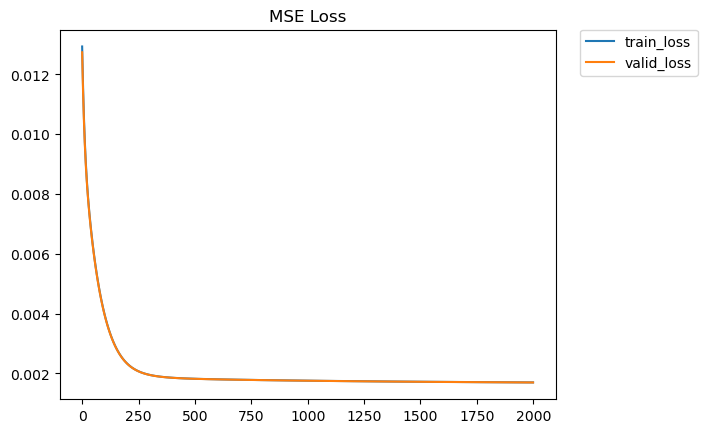

In [13]:
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [14]:
inputs = train_x.reshape(train_x.shape[0],train_x.shape[1],1)

len(inputs)

102

In [15]:
model.eval()

CNN_ForecastNet(
  (fc1): Linear(in_features=12, out_features=1, bias=True)
)

In [16]:
model.eval()
prediction = []
batch_size = 3
iterations =  int(inputs.shape[0]/3)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds[0].detach().numpy())
    prediction.append(preds[1].detach().numpy())
    prediction.append(preds[2].detach().numpy())
prediction = np.array(prediction)

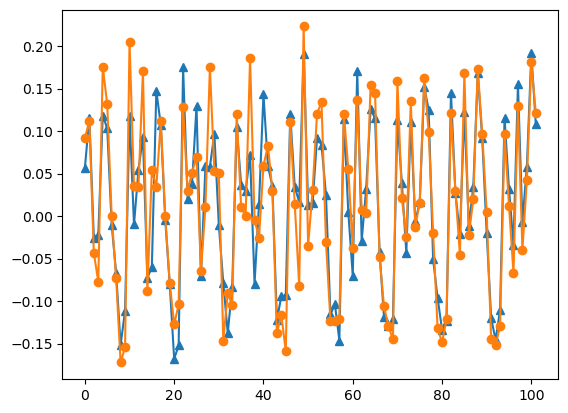

In [17]:
plt.plot(prediction, marker='^')
plt.plot(train_y, marker='o')
plt.show()

In [18]:
inputs = valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1)

len(inputs)

17

In [19]:
prediction = []
batch_size = 3
iterations =  int(inputs.shape[0]/3)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds[0].detach().numpy())
    prediction.append(preds[1].detach().numpy())
    prediction.append(preds[2].detach().numpy())
prediction = np.array(prediction)

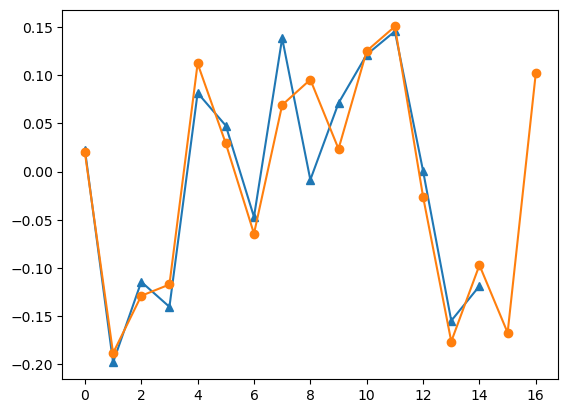

In [20]:
plt.plot(prediction, marker='^')
plt.plot(valid_y, marker='o')
plt.show()

In [21]:
error = 0

for i in range(len(prediction)):
    error = error + (prediction[i] - valid_y[i])**2
error/len(prediction)

array([0.00146744], dtype=float32)